In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from pprint import pprint
import astropy
print astropy.__version__
import math

class spectral_order:
    def __init__(self,wav,flux,error,order_number):
        self.order = order_number
        self.wav = wav
        self.flux_ergs = flux
        self.flux_watts = flux*10.
        self.error_ergs = error
        self.error_watts = error*10.
        self.snr = flux/error
        
        self.wavfluxmap = {wav[i]: flux[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.waverrmap = {wav[i]: error[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.wavsnrmap = {wav[i]: self.snr[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        

class arcoiris_spectrum(object):
    def __init__(self, name, data, date):
        ordernames = ['order3','order4','order5','order6','order7','order8']

        times_order_has_been_read = 0
        orders_read = 0
        ordernumbers = [3,4,5,6,7,8]
        
        orderwav = []
        orderflux = []
        ordererr = []
        
        fullwav = []
        fullflux = []
        fullerr = []
        
        for line in data: 
            if 'Order' in line:
                times_order_has_been_read += 1
                if times_order_has_been_read > 1:
                    orders_read += 1
                ordernumber = ordernumbers[orders_read]
                #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
                if len(orderwav) > 0:
                    orderwavvec = np.array(orderwav)
                    orderfluxvec = np.array(orderflux)
                    ordererrvec = np.array(ordererr)
                    
                    #print ordernames[orders_read-1]
                    setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                    
                    orderwav = []
                    orderflux = []
                    ordererr = []
                    
            else:
                conts = line.split()
                orderwav.append(float(conts[0]))
                orderflux.append(float(conts[1]))
                ordererr.append(float(conts[2]))
                fullwav.append(float(conts[0]))
                fullflux.append(float(conts[1]))
                fullerr.append(float(conts[2]))
                
                
        #print 'Out of loop'
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        orders_read += 1
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        
        setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                
        self.orderlist = [self.order3, self.order4, self.order5, self.order6, self.order7, self.order8]
        
        self.fullwav = np.array(fullwav)
        self.fullflux = np.array(fullflux)
        self.fullerr = np.array(fullerr)
        self.fullsnr = self.fullflux/self.fullerr
        
        self.objectname = name
        self.objectdate = date
        
        
                
    def plot_spectrum(self,snrthreshold,use_watts,temp_spec=None,f=None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        for order in self.orderlist:
            orderwav_plot = []
            orderflux_plot = []
            for i in range(len(order.wav)):
                if order.snr[i] > snrthreshold:
                    orderwav_plot.append(order.wav[i])
                    if use_watts:
                        orderflux_plot.append(order.flux_watts[i])
                    else:
                        orderflux_plot.append(order.flux_ergs[i])
            ax.plot(orderwav_plot, orderflux_plot)

        if temp_spec != None:
            ax.plot(temp_spec.short_wavelength,temp_spec.short_flux_density*f)            
            
        ax.set_xlim([0.8,2.4])
        
        #if use_watts:
        #    ax.set_ylim([0.,1.e-13])
        #else:
        #    ax.set_ylim([0.,1.e-14])
        
        ax.set_xlabel(r'Wavelength ($\mu$m)')
        if use_watts:
            ax.set_ylabel(r'Flux ($W/m^{2}/\mu m$)')
        else:
            ax.set_ylabel(r'Flux ($ergs s^{-1} cm^{-2} \AA^{-1}$)')
        
        if temp_spec != None:
            ax.set_title(r'Comparison of ' + self.objectname + ' to template')
        else:
            ax.set_title(self.objectname)
            
            
        return fig
                
    #def __str__(self):
        

class spex_spectrum(object):
    def __init__(self, data):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        full_wavelength_list = []
        full_flux_density_list = []
        full_error_list = []        
        short_wavelength_list = []
        short_flux_density_list = []
        short_error_list = []
        long_wavelength_list = []
        long_flux_density_list = []
        long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            error = float(comps[2])
        
            if (wav < -900.) or (flux < -900.) or (error < -900.):
                continue

            full_wavelength_list.append(float(comps[0]))
            full_flux_density_list.append(float(comps[1]))
            full_error_list.append(float(comps[2]))
            
            if wav < 2.75:
                short_wavelength_list.append(float(comps[0]))
                short_flux_density_list.append(float(comps[1]))
                short_error_list.append(float(comps[2]))
            else:
                long_wavelength_list.append(float(comps[0]))
                long_flux_density_list.append(float(comps[1]))
                long_error_list.append(float(comps[2]))                
        
        self.full_wavelength = np.array(full_wavelength_list)
        self.full_flux_density = np.array(full_flux_density_list)
        self.full_error = np.array(full_error_list)
        
        self.short_wavelength = np.array(short_wavelength_list)
        self.short_flux_density = np.array(short_flux_density_list)
        self.short_error = np.array(short_error_list)
        self.long_wavelength = np.array(long_wavelength_list)
        self.long_flux_density = np.array(long_flux_density_list)
        self.long_error = np.array(long_error_list)
    
        return

        
        

def write_arcoiris_to_file(filename,for_iraf):
    
    for file in glob.glob(filename):
        print 'making ', file, ' into a text file \n'
        hdulist = fits.open(file)
        #print hdulist.info()
        spectra = hdulist[0].data
        oldheader = hdulist[0].header
        #print spectra.shape
        #xwave_order3 = spectra[:,0,0]
        #xdata_order3 = spectra[:,1,0]
        #xerror_order3 = spectra[:,2,0]
    
        test = spectra[0,:,:]
        #print 'test:', test.shape
    
        test1 = spectra[0,0,:]
        #print 'test1:',test1.shape
        #print min(test1), max(test1)
        test2 = spectra[0,1,:]
        #print min(test2), max(test2)
        #print test1[0:2029]
        #print test2[0:2029]
    
        #xwave_order3 = spectra[0,0,0:2029]
        #xdata_order3 = spectra[0,1,0:2029]
    
        #xwave_order4 = spectra[1,0,0:2029]
        #xdata_order4 = spectra[1,1,0:2029]
    
        
    
        #pprint(oldheader)
        #print len(xwave)
        #print len(xdata)
        if for_iraf:
            F = open(file[:-5] + '_IRAF.txt','w')
            for i in range(6):
                for j in range(2030):
                    F.write(str(spectra[i,0,j]) + ' ' + str(spectra[i,1,j]) + ' ' + str(spectra[i,2,j]) + '\n')
        else:
            F = open(file[:5] + '_python.txt','w')
            for i in range(6):
                F.write('Order ' + str(i+3) + '\n')
                for j in range(2030):
                    F.write(str(spectra[i,0,j]) + ' ' + str(spectra[i,1,j]) + ' ' + str(spectra[i,2,j]) + '\n')
        F.close()
        
    return 'Done'

res = write_arcoiris_to_file('awi0005x3s_xtc_20171104.fits',False)
res0 = write_arcoiris_to_file('awi0005x3s_xtc_20171104.fits',True)
print res
print res0

res1 = write_arcoiris_to_file('awi0005x3s_xtc_20180301.fits',False)
res2 = write_arcoiris_to_file('awi0005x3s_xtc_20180301.fits',True)
print res1
print res2

res3 = write_arcoiris_to_file('awi0005x3s_xtc_20180302.fits',False)
res4 = write_arcoiris_to_file('awi0005x3s_xtc_20180302.fits',True)
print res3
print res4


    #plt.figure()
    #plt.plot(xwave_order3, xdata_order3)
    #plt.plot(xwave_order4, xdata_order4)
    #plt.ylim([0., 2.e-15])
    #plt.show()
    
    #print xwave_order3[800]
    #print xwave_order3[1150]
    
    #plt.figure()
    #plt.plot(xwave_order3[800:1150], xdata_order3[800:1150])
    #plt.show()


2.0.2
making  awi0005x3s_xtc_20171104.fits  into a text file 



 ############################## Xspextool History ############################## [astropy.io.fits.card]
 ############################## Xcombspec History ############################## [astropy.io.fits.card]
 ############################### Xtellcor History ############################## [astropy.io.fits.card]


making  awi0005x3s_xtc_20171104.fits  into a text file 

Done
Done
making  awi0005x3s_xtc_20180301.fits  into a text file 

making  awi0005x3s_xtc_20180301.fits  into a text file 

Done
Done
making  awi0005x3s_xtc_20180302.fits  into a text file 

making  awi0005x3s_xtc_20180302.fits  into a text file 

Done
Done


First row found: 47
First row found: 47


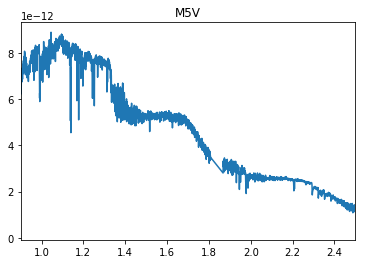

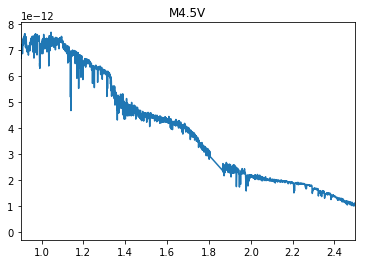

In [3]:
def import_spex_spectrum_from_file(filename):
    
    with open(filename) as f:
        imported_data = f.readlines()
        
    spectrum = spex_spectrum(imported_data)
    return spectrum
        

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')

boucher_template = import_spex_spectrum_from_file('M4point5V_Gl268AB.txt')

plt.figure()
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density)
plt.title('M5V')
plt.xlim([0.9,2.5])
plt.show()

plt.figure()
plt.plot(boucher_template.full_wavelength, boucher_template.full_flux_density)
plt.title('M4.5V')
plt.xlim([0.9,2.5])
plt.show()

AWI0005x3s read in
making  boucher_xtc.fits  into a text file 

Done
making  boucher_xtc.fits  into a text file 

Done
Boucher read in
Boucher
min: 1.88226 max: 2.46585
min: 1.88234 max: 2.46532
min: 1.8826 max: 2.46592
2.466373
20171104: 3143:4386
20180301: 3144:4385
20180302: 3144:4387


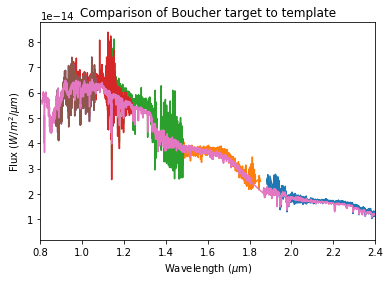

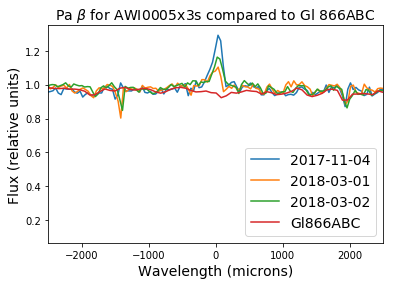

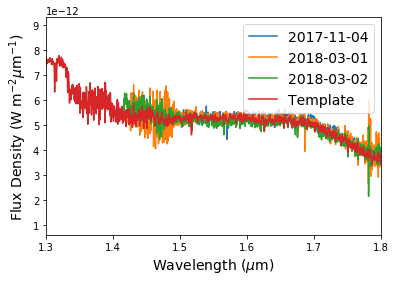

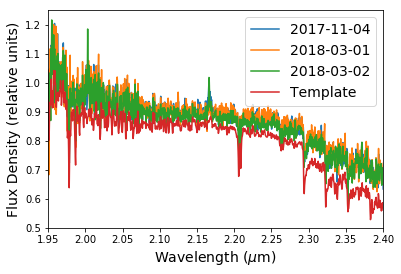

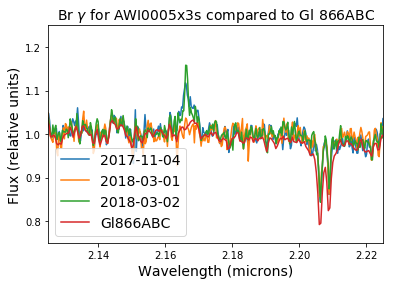

In [8]:
def import_arcoiris_spectrum_from_file(targetname, filename, date):
    
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_spectrum(targetname, data, date)
    
    return spectrum

AWI0005x3s_20171104 = import_arcoiris_spectrum_from_file('AWI0005x3s','awi0005x3s_xtc_20171104_python.txt','2017-11-04')
AWI0005x3s_20180301 = import_arcoiris_spectrum_from_file('AWI0005x3s','awi0005x3s_xtc_20180301_python.txt','2018-03-01')
AWI0005x3s_20180302 = import_arcoiris_spectrum_from_file('AWI0005x3s','awi0005x3s_xtc_20180302_python.txt','2018-03-02')
print 'AWI0005x3s read in'
#print AWI0005x3s_20171104.__dict__


boucher_res = write_arcoiris_to_file('boucher_xtc.fits',False)
print boucher_res
boucher_res0 = write_arcoiris_to_file('boucher_xtc.fits',True)
print boucher_res0

boucher_spectrum = import_arcoiris_spectrum_from_file('Boucher target','boucher_xtc_python.txt','2017-11-04')
print 'Boucher read in'

#plt.figure()
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0025)
#plt.xlim([0.8,2.4])
#plt.ylim([0.,1.e-13])
#plt.xlabel(r'Wavelength ($\mu$m)')
#plt.ylabel(r'Flux Density (W m$^{-2} \mu$m$^{-1}$)')
#plt.show()

pagamma_lamb0 = 1.282006
padelta_lamb0 = 1.093978
brgamma_lamb0 = 2.165856

def plot_multiple_spectra_order4(spectrum_list, snrthreshold, template_spectrum, f_list):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    for i in range(len(spectrum_list)):
        spectrum = spectrum_list[i]
        f = f_list[i]
        specwav = np.array([spectrum.order4.wav[i] for i in range(spectrum.order4.wav.size) if spectrum.order4.snr[i] > snrthreshold])
        specflux = np.array([spectrum.order4.flux_watts[i] for i in range(spectrum.order4.wav.size) if spectrum.order4.snr[i] > snrthreshold])
        
        ax.plot(specwav, specflux/f, label=spectrum.objectdate)
        
    ax.set_xlim([1.3,1.8])
    ax.set_xlabel(r'Wavelength ($\mu$m)',fontsize=14)
    ax.set_ylabel(r'Flux Density (W m$^{-2} \mu$m$^{-1}$)',fontsize=14)
    
    ax.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density,label='Template')
    
    plt.legend(loc='upper right',fontsize=14)

    return fig

def plot_multiple_spectra_order3(spectrum_list, snrthreshold, template_spectrum, f_list, fill_factor):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    for i in range(len(spectrum_list)):
        spectrum = spectrum_list[i]
        f = f_list[i]
        specwav = np.array([spectrum.order3.wav[i] for i in range(spectrum.order3.wav.size) if spectrum.order3.snr[i] > snrthreshold])
        specflux = np.array([spectrum.order3.flux_watts[i] for i in range(spectrum.order3.wav.size) if spectrum.order3.snr[i] > snrthreshold])
        
        ax.plot(specwav, specflux/f/fill_factor, label=spectrum.objectdate)
        
    ax.set_xlim([1.95,2.4])
    #ax.set_ylim([1.75e-12,4.0e-12])
    ax.set_ylim([0.5,1.25])
    ax.set_xlabel(r'Wavelength ($\mu$m)',fontsize=14)
    ax.set_ylabel(r'Flux Density (relative units)',fontsize=14)
    
    ax.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/fill_factor,label='Template')
    
    plt.legend(loc='upper right',fontsize=14)

    return fig


#AWI0005x3s_20171104_fig = AWI0005x3s_20171104.plot_spectrum(20,True,temp_spec=template_spectrum,f=0.0025)
#plt.show(AWI0005x3s_20171104_fig)

#AWI0005x3s_20180301_fig = AWI0005x3s_20180301.plot_spectrum(20,True,temp_spec=template_spectrum,f=0.0026)
#plt.show(AWI0005x3s_20180301_fig)

#AWI0005x3s_20180302_fig = AWI0005x3s_20180302.plot_spectrum(20,True,temp_spec=template_spectrum,f=0.00245)
#plt.show(AWI0005x3s_20180302_fig)

print 'Boucher'
boucher_spectrum_fig = boucher_spectrum.plot_spectrum(20,True,temp_spec=boucher_template,f=0.0085)
boucher_spectrum_fig.savefig('boucher_comparison_fig.png')

print "min:", min(AWI0005x3s_20171104.order3.wav), "max:", max(AWI0005x3s_20171104.order3.wav)
print "min:", min(AWI0005x3s_20180301.order3.wav), "max:", max(AWI0005x3s_20180301.order3.wav)
print "min:", min(AWI0005x3s_20180302.order3.wav), "max:", max(AWI0005x3s_20180302.order3.wav)


print template_spectrum.short_wavelength[4388]
print "20171104: 3143:4386"
print "20180301: 3144:4385"
print "20180302: 3144:4387"



plt.figure()
plt.plot(((AWI0005x3s_20171104.order5.wav[600:1100]-pagamma_lamb0)/pagamma_lamb0) * 299792.458, AWI0005x3s_20171104.order5.flux_watts[600:1100]/(2.e-14),label='2017-11-04')
plt.plot(((AWI0005x3s_20180301.order5.wav[600:1100]-pagamma_lamb0)/pagamma_lamb0) * 299792.458, AWI0005x3s_20180301.order5.flux_watts[600:1100]/(2.e-14),label='2018-03-01')
plt.plot(((AWI0005x3s_20180302.order5.wav[600:1100]-pagamma_lamb0)/pagamma_lamb0) * 299792.458, AWI0005x3s_20180302.order5.flux_watts[600:1100]/(2.e-14)/0.95,label='2018-03-02')
plt.plot(((template_spectrum.short_wavelength-pagamma_lamb0)/pagamma_lamb0) * 299792.458, template_spectrum.short_flux_density*0.0025/(2.e-14),label='Gl866ABC')
plt.xlim([-2500.,2500.])
plt.xlabel('Wavelength (microns)',fontsize=14)
plt.ylabel(r'Flux (relative units)',fontsize=14)
plt.title(r'Pa $\beta$ for AWI0005x3s compared to Gl 866ABC',fontsize=14)
plt.legend(loc='lower right',fontsize=14)
#plt.savefig('paschen_beta_comp.png')
plt.show()

comparison_fig_order4 = plot_multiple_spectra_order4([AWI0005x3s_20171104, AWI0005x3s_20180301, AWI0005x3s_20180302], 20., template_spectrum, [0.0025, 0.0026, 0.00245])
#plt.show(comparison_fig_order4)
comparison_fig_order4.savefig('comparison_fig_order4.png')

comparison_fig_order3 = plot_multiple_spectra_order3([AWI0005x3s_20171104, AWI0005x3s_20180301, AWI0005x3s_20180302], 20., template_spectrum, [0.0025, 0.0026, 0.00245], 3.0e-12)
#plt.show(comparison_fig_order3)
comparison_fig_order3.savefig('comparison_fig_order3.png')

#print AWI0005x3s_20171104.order3.wav[843]
#print AWI0005x3s_20171104.order3.wav[1191]
AWI0005x3s_20171104_median = np.median(AWI0005x3s_20171104.order3.flux_watts[843:1192])

#print AWI0005x3s_20180301.order3.wav[844]
#print AWI0005x3s_20180301.order3.wav[1192]
AWI0005x3s_20180301_median = np.median(AWI0005x3s_20180301.order3.flux_watts[844:1193])

#print AWI0005x3s_20180302.order3.wav[843]
#print AWI0005x3s_20180302.order3.wav[1191]
AWI0005x3s_20180302_median = np.median(AWI0005x3s_20180302.order3.flux_watts[843:1192])

plt.figure()
plt.plot(AWI0005x3s_20171104.order3.wav, AWI0005x3s_20171104.order3.flux_watts/AWI0005x3s_20171104_median,label='2017-11-04')
plt.plot(AWI0005x3s_20180301.order3.wav, AWI0005x3s_20180301.order3.flux_watts/AWI0005x3s_20180301_median,label='2018-03-01')
plt.plot(AWI0005x3s_20180302.order3.wav, AWI0005x3s_20180302.order3.flux_watts/AWI0005x3s_20180302_median,label='2018-03-02')
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00265/(6.8e-15),label='Gl866ABC')
plt.xlim([2.125,2.225])
plt.ylim([0.75,1.25])
plt.xlabel('Wavelength (microns)',fontsize=14)
plt.ylabel(r'Flux (relative units)',fontsize=14)
plt.title(r'Br $\gamma$ for AWI0005x3s compared to Gl 866ABC',fontsize=14)
plt.legend(loc='lower left',fontsize=14)
#plt.savefig('brackett_gamma_comp.png')
plt.show()

plt.figure()
plt.plot(AWI0005x3s_20171104.order3.wav, AWI0005x3s_20171104.order3.flux_watts/AWI0005x3s_20171104_median,label='2017-11-04')
plt.plot(AWI0005x3s_20180301.order3.wav, AWI0005x3s_20180301.order3.flux_watts/AWI0005x3s_20180301_median,label='2018-03-01')
plt.plot(AWI0005x3s_20180302.order3.wav, AWI0005x3s_20180302.order3.flux_watts/AWI0005x3s_20180302_median,label='2018-03-02')
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00265/(6.8e-15),label='Gl866ABC')
plt.xlim([2.19,2.225])
plt.ylim([0.75,1.25])
plt.xlabel('Wavelength (microns)',fontsize=14)
plt.ylabel(r'Flux (relative units)',fontsize=14)
plt.title(r'Absorption variability for AWI0005x3s compared to Gl 866ABC',fontsize=14)
plt.legend(loc='lower left',fontsize=14)
plt.savefig('absorption_comp.png')
#plt.show()




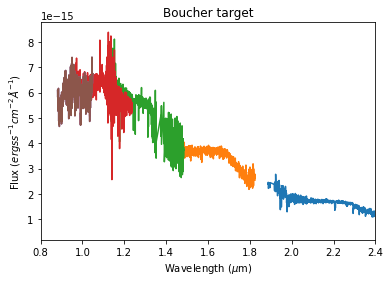

In [133]:
boucher_fig = boucher_spectrum.plot_spectrum(30,False)
plt.show(boucher_fig)

plt.figure()
plt.plot(boucher_spectrum.order5.wav, boucher_spectrum.order5.flux_watts/(1.0e-14)/5.75,label='Boucher')
plt.plot(boucher_template.short_wavelength, boucher_template.short_flux_density*0.009/(1.0e-14)/5.75,label='Template')
plt.xlim([1.25,1.31])
plt.ylim([0.75,1.25])
plt.xlabel('Wavelength (microns)',fontsize=14)
plt.ylabel(r'Flux (relative units)',fontsize=14)
plt.title(r'Pa $\beta$ for Boucher target',fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.savefig('boucher_paschen_beta_comp.png')

plt.figure()
plt.plot(boucher_spectrum.order3.wav, boucher_spectrum.order3.flux_watts/(1.71e-14),label='Boucher')
plt.plot(boucher_template.short_wavelength, boucher_template.short_flux_density*0.00875/(1.71e-14),label='Template')
plt.xlim([2.14,2.2])
#plt.ylim([0.,2.0e-14])
plt.ylim([0.75,1.25])
plt.xlabel('Wavelength (microns)',fontsize=14)
plt.ylabel(r'Flux (relative units)',fontsize=14)
plt.title(r'Br $\gamma$ for Boucher target',fontsize=14)
plt.legend(loc='upper right')
plt.savefig('boucher_brackett_gamma_comp.png')

making  AWI0005x3s_xtc_20171104_modVega.fits  into a text file 

Done
making  HD74562_comb_new_20171104.fits  into a text file 

Done


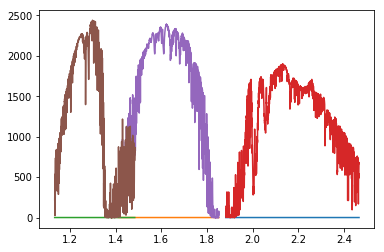

In [18]:
res5 = write_arcoiris_to_file('AWI0005x3s_xtc_20171104_modVega.fits',False)
print res5

res6 = write_arcoiris_to_file('HD74562_comb_new_20171104.fits',False)
print res6

AWI0005x3s_20171104_modVega = import_arcoiris_spectrum_from_file('AWI0005x3s_modVega','awi00_python.txt','2017-11-04')
HD74562_20171104 = import_arcoiris_spectrum_from_file('HD74562','HD745_python.txt','2017-11-04')

plt.figure()
plt.plot(AWI0005x3s_20171104_modVega.order3.wav,AWI0005x3s_20171104_modVega.order3.flux_ergs)
plt.plot(AWI0005x3s_20171104_modVega.order4.wav,AWI0005x3s_20171104_modVega.order4.flux_ergs)
plt.plot(AWI0005x3s_20171104_modVega.order5.wav,AWI0005x3s_20171104_modVega.order5.flux_ergs)
plt.plot(HD74562_20171104.order3.wav, HD74562_20171104.order3.flux_ergs)
plt.plot(HD74562_20171104.order4.wav, HD74562_20171104.order4.flux_ergs)
plt.plot(HD74562_20171104.order5.wav, HD74562_20171104.order5.flux_ergs)
plt.show()

#modVega_fig = AWI0005x3s_20171104_modVega.plot_spectrum(20,False)
#boucher_spectrum_fig.savefig('boucher_comparison_fig.png')
#modVega_fig.savefig('20171104_modVega.png')

In [ ]:
import time

print time.time() - 1524880146.44